In [4]:
from fastbook import *

In [5]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls), urls[0]

(1,
 'https://fthmb.tqn.com/tvPe1GjuUCasntTK2maHH_0FBZo=/1280x853/filters:fill(auto,1)/gouldian-finch-188062467-resized-58a6ea6e5f9b58a3c9190af4.jpg')

In [6]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=True)

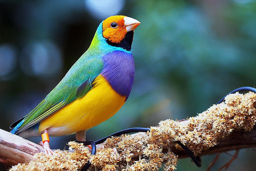

In [7]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [14]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200], max_pics=200)
        resize_images(dest, max_size=400, dest=dest)


In [15]:
failed = verify_images(get_image_files(path))
failed .map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None,None,None]

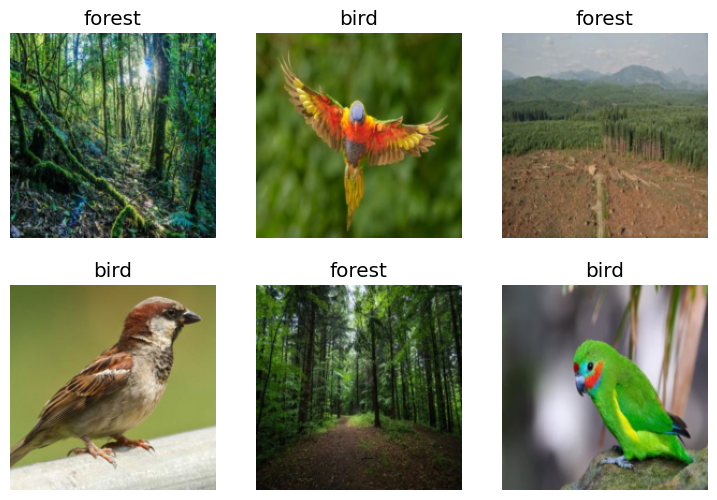

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.310192,0.661979,0.271429,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.163429,0.088407,0.014286,00:01
1,0.103802,0.048775,0.014286,00:01
2,0.069910,0.049335,0.014286,00:01


In [24]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998


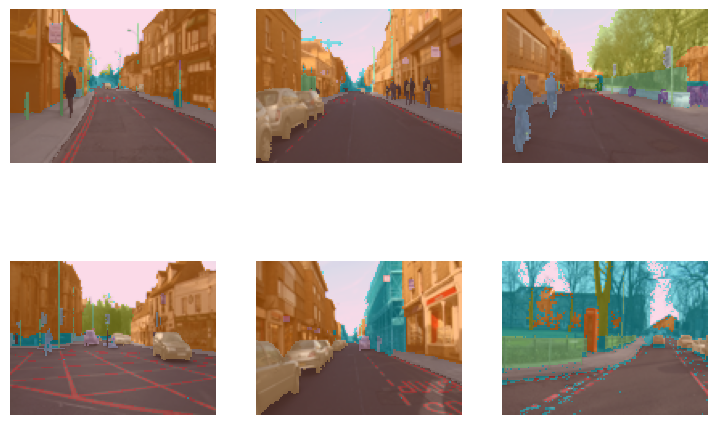

In [25]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

dls.show_batch(max_n=6)

In [26]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/juliankmazo/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [01:20<00:00, 1.08MB/s]


epoch,train_loss,valid_loss,time
0,2.708482,2.056653,00:05


epoch,train_loss,valid_loss,time
0,1.769269,1.576660,00:01
1,1.590623,1.476752,00:01
2,1.444951,1.215559,00:01
3,1.340775,1.062096,00:01
4,1.212428,0.871493,00:01
5,1.094947,0.826754,00:01
6,0.997592,0.795787,00:01
7,0.919265,0.768369,00:01


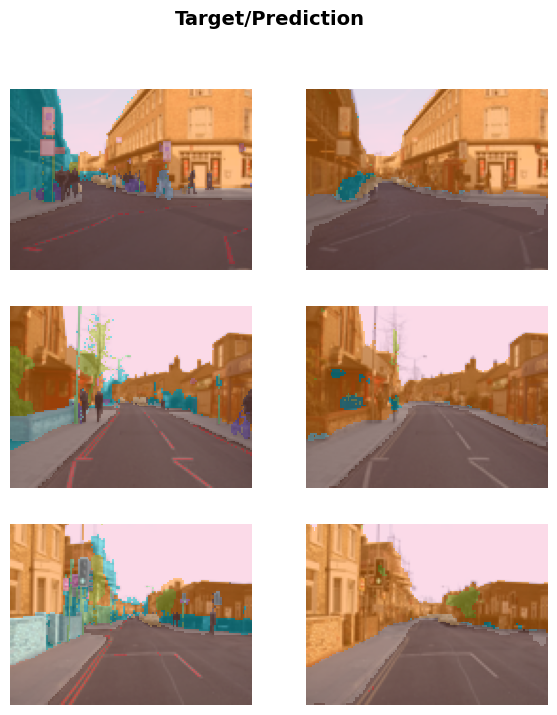

In [28]:
learn.show_results(max_n=3, figsize=(7,8))

In [29]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(
    path/'adult.csv',
    path=path,
    y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize]
)

dls.show_batch()

/Users/juliankmazo/Developer/personal/ai-engineering-learning/.venv/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Never-married,Other-service,Not-in-family,White,False,30.000000,203258.000309,9.0,<50k
1,Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,31.000000,161764.999245,10.0,<50k
2,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,45.000000,225455.999819,13.0,>=50k
3,Private,Some-college,Married-civ-spouse,Handlers-cleaners,Husband,White,False,35.000000,29873.995779,10.0,<50k
4,Private,Bachelors,Widowed,Sales,Unmarried,White,False,53.999999,220054.998785,13.0,<50k
5,Self-emp-not-inc,Prof-school,Married-civ-spouse,Farming-fishing,Husband,White,False,42.000000,177306.999686,15.0,>=50k
6,Private,10th,Never-married,Other-service,Unmarried,Black,False,34.000000,224357.998651,6.0,<50k
7,Private,HS-grad,Married-civ-spouse,#na#,Husband,White,True,35.000000,306678.000975,10.0,<50k
8,Private,11th,Never-married,Transport-moving,Own-child,White,False,28.000000,181658.999623,7.0,<50k
9,Local-gov,Some-college,Never-married,Adm-clerical,Other-relative,Black,False,28.000000,125158.999131,10.0,<50k


In [33]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.384865,0.364146,0.834613,00:03
1,0.360456,0.354940,0.836916,00:03


In [34]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

dls.show_batch(max_n=6)

,userId,movieId,rating
0,247,597,3.0
1,460,1704,4.0
2,262,231,2.5
3,564,648,2.0
4,382,595,4.0
5,119,356,3.0
6,111,1580,4.0
7,596,4993,3.0
8,598,1197,5.0
9,165,231,4.0


In [35]:
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.457150,1.456222,00:00


epoch,train_loss,valid_loss,time
0,1.350879,1.396981,00:00
1,1.254346,1.226145,00:00
2,1.019569,0.927221,00:00
3,0.804505,0.773694,00:00
4,0.687612,0.743381,00:00
5,0.641746,0.728659,00:00
6,0.604064,0.723644,00:00
7,0.598109,0.723617,00:00
8,0.593159,0.722885,00:00
9,0.611285,0.722789,00:00
